In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d
import utilities as u
import preprocessing as pp
import behavior as b

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
df = pp.load_session_db()
df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
# tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]
df = df[(df['ImagingRegion']=="") | (df['ImagingRegion']=="CA1")]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [55]:
# function for getting lick and speed data

def load_lick_mat(sess):
    VRDat= pp.behavior_dataframe(sess['data file'])
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
    lick_trial_mat= u.make_pos_bin_trial_matrices(VRDat['lick']._values,
                                                            VRDat['pos']._values,
                                                            VRDat['tstart']._values,
                                                            VRDat['teleport']._values,
                                                            mat_only=True,bin_size=10)
    return lick_trial_mat, trial_info


def build_matrix(mouse_list,first_sess=5,df=df):
    
    fs = u._first_sess_gen(mouse_list,first_sess)
    L= {}
    for m, (mouse,_fs) in enumerate(zip(mouse_list,fs)):    
        print(mouse)
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for i, sess_ind in enumerate(range(_fs,df_mouse.shape[0])):
            lick_mat, trial_info = load_lick_mat(df_mouse.iloc[sess_ind])
            _mu, l = u.across_trial_avg(lick_mat,trial_info['morphs'])
            
            if i==0:
                lick_mu = lick_mat
                morph = trial_info['morphs']#+trial_info['towerJitter']+trial_info['bckgndJitter']+trial_info['wallJitter']
                rzone_pos = trial_info['rzone_entry']
            else:
                lick_mu = np.concatenate((lick_mu,lick_mat),axis=0)
                morph = np.concatenate((morph,trial_info['morphs']))
                rzone_pos = np.concatenate((rzone_pos,trial_info['rzone_entry']))
            
                
        L[mouse]={}
        L[mouse]['licks']=lick_mu
        L[mouse]['morphs']=morph
        L[mouse]['rzone_pos']=rzone_pos
        
       
        
    return L



In [5]:
LD_rare = build_matrix(['4139265.3','4139265.4','4139265.5','4222168.1'],first_sess=[5,5,5,3])
LD_fam = build_matrix(['4222153.1','4222153.2','4222153.3','4222154.1','4222174.1'],first_sess=4)
LD_all = build_matrix(['4139265.3','4139265.4','4139265.5','4222168.1','4222153.1','4222153.2','4222153.3','4222154.1','4222174.1'],first_sess=[5,5,5,3,4,4,4,4,4])

4139265.3


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


4139265.4
4139265.5
4222168.1
4222153.1
4222153.2
4222153.3
4222154.1
4222174.1
4139265.3
4139265.4
4139265.5
4222168.1
4222153.1
4222153.2
4222153.3
4222154.1
4222174.1


(600, 45)
(720, 45)
(600, 45)
(490, 45)
(281, 45)
(425, 45)
(90, 45)
(510, 45)
(400, 45)


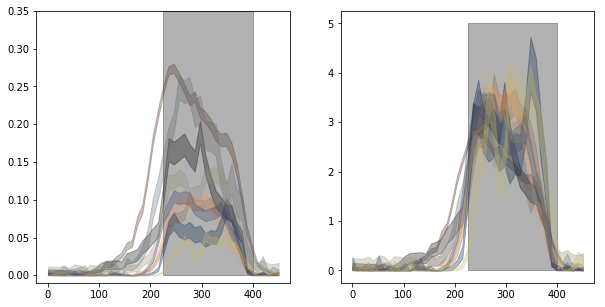

In [6]:
f,ax = plt.subplots(1,2,figsize=[10,5])
nbins = 45
cmaps = ['copper','cividis']



for i,L in enumerate([LD_rare,LD_fam]):
    nmice = len(L.keys())
    cm  = plt.cm.get_cmap(cmaps[i])
    
    for z, mouse in enumerate(L.keys()):
        licks = L[mouse]['licks']
        #licks/=licks.ravel().mean()
        morphs = L[mouse]['morphs']
        print(licks.shape)
        mu = licks.mean(axis=0)
        sem = sp.stats.sem(licks,axis=0)
        
        
        ax[0].fill_between(np.linspace(0,450,num=nbins),mu-sem,y2=mu+sem,alpha=.3,color=cm(np.float(z/nmice)))
        ax[0].set_ylim([-.01,.35])
        
        licks_n = np.copy(licks)
        licks_n/=licks_n.ravel().mean()
        mu = licks_n.mean(axis=0)
        sem = sp.stats.sem(licks_n,axis=0)
        
        ax[1].fill_between(np.linspace(0,450,num=nbins),mu-sem,y2=mu+sem,alpha=.3,color=cm(np.float(z/nmice)))
ax[0].fill_betweenx([0,.35],225,400,color='black',alpha=.3,zorder=0)
ax[1].fill_betweenx([0,5],225,400,color='black',alpha=.3,zorder=0)
#         ax[1,i].set_ylim([-.01,.35])
        
#         #         sem/=norm
#         for j, m in enumerate([0.,.25,.5,.75,1.]):
#             mask = morphs==m
#             mu = licks[mask,:].mean(axis=0)
#             sem = sp.stats.sem(licks[mask,:],axis=0)
            
#             ax[j+1,i].fill_between(np.linspace(0,450,num=nbins),mu-sem,y2=mu+sem,alpha=.3,color=cm(np.float(z/nmice)))
#             ax[j+1,i].set_ylim([-.01,.35])
#             ax[j+1,i].set_title("%f" % m)
            
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\python_outputs\\licking_behavior.pdf",format='pdf')

4139265.3
(600, 45)
4139265.4
(720, 45)
4139265.5
(600, 45)
4222168.1
(490, 45)
4222153.1
(281, 45)
4222153.2
(425, 45)
4222153.3
(90, 45)
4222154.1
(510, 45)
4222174.1
(400, 45)


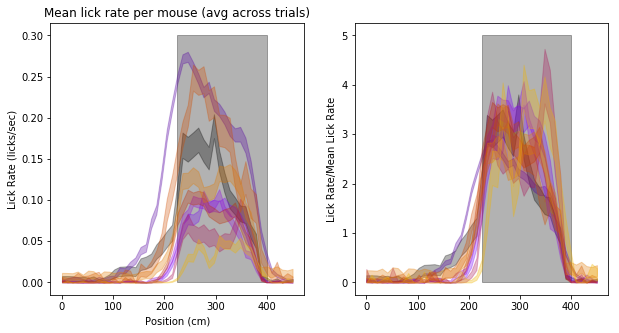

In [7]:
LD = LD_all


f,ax = plt.subplots(1,2,figsize=[10,5])
nbins = 45
# cmaps = ['gnuplot']

nmice = len(LD_all.keys())
cm  = plt.cm.get_cmap('gnuplot')

for z, mouse in enumerate(LD_all.keys()):
    print(mouse)
    licks = LD_all[mouse]['licks']
    #licks/=licks.ravel().mean()
    morphs = LD_all[mouse]['morphs']
    print(licks.shape)
    mu = licks.mean(axis=0)
    sem = sp.stats.sem(licks,axis=0)


    ax[0].fill_between(np.linspace(0,450,num=nbins),mu-sem,y2=mu+sem,alpha=.3,color=cm(np.float(z/nmice)))
#     ax[0].set_ylim([-.01,.35])

    licks_n = np.copy(licks)
    licks_n/=licks_n.ravel().mean()
    mu = licks_n.mean(axis=0)
    sem = sp.stats.sem(licks_n,axis=0)

    ax[1].fill_between(np.linspace(0,450,num=nbins),mu-sem,y2=mu+sem,alpha=.3,color=cm(np.float(z/nmice)))

ax[0].fill_betweenx([0,.3],225,400,color='black',alpha=.3,zorder=0)
ax[1].fill_betweenx([0,5],225,400,color='black',alpha=.3,zorder=0)
ax[0].set_ylabel('Lick Rate (licks/sec)')
ax[0].set_xlabel('Position (cm)')
ax[1].set_ylabel('Lick Rate/Mean Lick Rate')
ax[0].set_title('Mean lick rate per mouse (avg across trials)')
            
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\python_outputs\\allmice_licking_acrossmorphs.pdf",format='pdf')

In [8]:
# function for lick accuracy (percent of licks in 50 cm preceding reward bin)
def pos_binned_licks(lick_mat,rpos,rz_edges=[220,260,290,320,380,481]):
    rpos[np.isnan(rpos)]=480
    rz_bins = np.digitize(rpos,rz_edges)-1
    
    mu_mat = np.zeros([len(rz_edges)-1,lick_mat.shape[1]])
    for b in range(len(rz_edges)-1):
        mu_mat[b,:] = lick_mat[rz_bins==b,:].mean(axis=0)
    return mu_mat


def lick_accuracy(lick_mat,edges,trial_info):
    pass
    #find rzone entry bin
    
    # sort lickmat by this value
    
    # plot peri reward zone licking
    
    

In [9]:
rz_edges=[220,260,290,320,380,481]
nmice = len(LD_all.keys())
# f,ax = plt.subplots()

MU_MAT=[]
for z, mouse in enumerate(LD_all.keys()):
    licks = LD_all[mouse]['licks']
    licks_n = np.copy(licks)
    licks_n/=licks.ravel().mean()
    
    rpos = LD_all[mouse]['rzone_pos']
#     print(licks.shape,licks_n.shape,rpos.shape)
    _mu_mat = pos_binned_licks(licks_n,rpos,rz_edges=rz_edges)
    MU_MAT.append(_mu_mat)
MU_MAT = np.squeeze(np.array(MU_MAT))
print(MU_MAT.shape)

(9, 5, 45)


(5, 45)


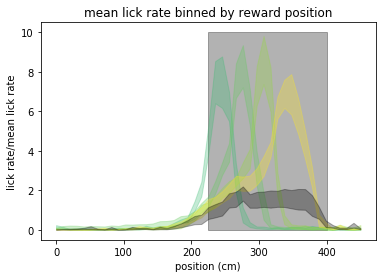

In [10]:
f,ax = plt.subplots()
ax.fill_betweenx([0,10],225,400,color='black',alpha=.3,zorder=0)

lr,sem = MU_MAT.mean(axis=0),sp.stats.sem(MU_MAT,axis=0)
print(lr.shape)
for b in range(len(rz_edges)-1):
    if b==4:
        ax.fill_between(np.linspace(0,450,num=nbins),lr[b,:]-sem[b,:],lr[b,:]+sem[b,:],color='black',alpha=.3)
    else:
        ax.fill_between(np.linspace(0,450,num=nbins),lr[b,:]-sem[b,:],lr[b,:]+sem[b,:],color=plt.cm.viridis(rz_edges[b+1]/rz_edges[4]),alpha=.3)
        
ax.set_ylabel('lick rate/mean lick rate')
ax.set_xlabel('position (cm)')
ax.set_title('mean lick rate binned by reward position')
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\python_outputs\\allmice_licking_posbin.pdf",format='pdf')

In [11]:
dff = pp.load_session_db()
dff = dff[dff['RewardCount']>30]
dff = dff[dff['Imaging']==1]
dff = dff.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|FreqMorph_Decision'
dff = dff[dff['Track'].str.contains(tracks,regex=True)]
dff = dff[(dff['ImagingRegion']=="") | (dff['ImagingRegion']=="CA1")]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [12]:
mouse = '4139224.2'
dff_mouse = dff[dff['MouseName'].str.match(mouse)]
dff_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
787,4139224.2,17_10_2018,1,TwoTower_noTimeout,60,1,CA1,2018-10-17,G:\My Drive\VR_Data\TwoTower\4139224.2\17_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\17_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\17_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\17_10_2...
802,4139224.2,18_10_2018,2,TwoTower_noTimeout,58,1,CA1,2018-10-18,G:\My Drive\VR_Data\TwoTower\4139224.2\18_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\18_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\18_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\18_10_2...
826,4139224.2,19_10_2018,2,TwoTower_noTimeout,60,1,CA1,2018-10-19,G:\My Drive\VR_Data\TwoTower\4139224.2\19_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\19_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\19_10_2...,G:\My Drive\2P_Data\TwoTower\4139224.2\19_10_2...


In [13]:
sess = dff_mouse.iloc[-1]
VRDat= pp.behavior_dataframe(sess['data file'])
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
lick_trial_mat,occ, edges,centers= u.make_pos_bin_trial_matrices(VRDat['lick']._values,
                                                        VRDat['pos']._values,
                                                        VRDat['tstart']._values,
                                                        VRDat['teleport']._values,
                                                        mat_only=False,bin_size=10)



In [14]:
em = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['towerJitter']+trial_info['wallJitter']


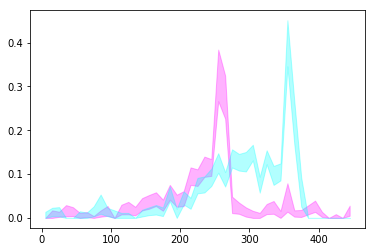

In [15]:
f,ax = plt.subplots()

t1_mask = em<=.5
mu,sem = np.nanmean(lick_trial_mat[t1_mask,:],axis=0),sp.stats.sem(lick_trial_mat[t1_mask,:],axis=0,nan_policy='omit')
ax.fill_between(centers,mu+sem,mu-sem,color=plt.cm.cool(1.),alpha=.3)
mu,sem = np.nanmean(lick_trial_mat[~t1_mask,:],axis=0),sp.stats.sem(lick_trial_mat[~t1_mask,:],axis=0,nan_policy='omit')
ax.fill_between(centers,mu+sem,mu-sem,color=plt.cm.cool(0.),alpha=.3)

In [16]:
['4222157.4','4222169.1','4222169.2','4222169.4']

['4222157.4', '4222169.1', '4222169.2', '4222169.4']

In [61]:
# LD_dec = build_matrix(['4222169.1','4222169.2','4222169.4','4139278.2','4222174.1'],first_sess=[4,4,4,4,0],df=dff)
LD_dec = build_matrix(['4222169.1','4222169.2','4222169.4'],first_sess=[4,4,4],df=dff)

4222169.1
4222169.2
4222169.4


In [62]:

nmice = len(LD_dec.keys())
morphs = [0,.25,.5,.75,1.]
mu_mat = np.zeros([len(morphs),45,len(LD_dec.keys())])
for z, mouse in enumerate(LD_dec.keys()):
    licks = LD_dec[mouse]['licks']
    licks_n = np.copy(licks)
    licks_n/=licks.ravel().mean()
    
    em = LD_dec[mouse]['morphs']
    for i,_mu in enumerate(morphs):
        mask = em==_mu #(em>morphs[i]) & (em<=_mu)
        mu_mat[i,:,z] = np.nanmean(licks_n[mask,:],axis=0)
#     MU_0.append(np.nanmean(licks_n[t1_mask,:],axis=0))
#     MU_1.append(np.nanmean(licks_n[t2_mask,:],axis=0))
    
# MU_0,MU_1 = np.squeeze(np.array(MU_0)),np.squeeze(np.array(MU_1))
# print(MU_0.shape,MU_1.shape)
print(mu_mat.shape)

(5, 45, 3)


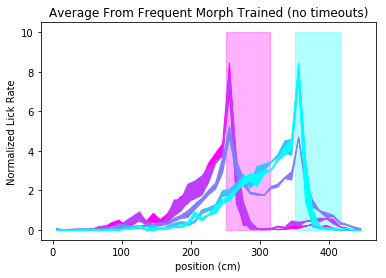

In [64]:
f,ax = plt.subplots()
for i,_mu in enumerate(morphs):
    mu,sem = mu_mat[i,:,:].mean(axis=-1),sp.stats.sem(mu_mat[i,:,:],axis=-1)
    ax.fill_between(centers,mu+sem,mu-sem,color=plt.cm.cool(1-np.float(_mu)))

# mu,sem = MU_0.mean(axis=0),sp.stats.sem(MU_0,axis=0)
# ax.fill_between(centers,mu+sem,mu-sem,color=plt.cm.cool(1.))
# mu,sem = MU_1.mean(axis=0),sp.stats.sem(MU_1,axis=0)
ax.fill_between(centers,mu+sem,mu-sem,color=plt.cm.cool(0.))
ax.fill_betweenx([0,10],250,315,color=plt.cm.cool(1.),alpha=.3,zorder=0)
ax.fill_betweenx([0,10],350,415,color=plt.cm.cool(0.),alpha=.3,zorder=0)
ax.set_ylabel('Normalized Lick Rate')
ax.set_xlabel('position (cm)')
ax.set_title('Average From Frequent Morph Trained (no timeouts)')
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\python_outputs\\freqmorph_noTO_licking.pdf",format='pdf')